In [1]:
import torch.nn as nn
import torchvision
import torch.utils.data
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image as Image
from models.tiny_gan import *

In [2]:
# Hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 16
img_size = 32
color_channels = 3
latent_vector_size = 50
feature_map_size = 32
training_episodes = 24
learning_rate_g = 0.0002
learning_rate_d = 0.0002
beta1 = 0.5

In [3]:
# Dataset loading
folder_train = torchvision.datasets.ImageFolder(
    root="../train_gan",
    transform=torchvision.transforms.Compose([
        torchvision.transforms.Resize(img_size),
        torchvision.transforms.CenterCrop(img_size),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
)

train_loader = torch.utils.data.DataLoader(
    folder_train,
    batch_size=batch_size,
    shuffle=True
)

In [4]:
generator = TinyGenerator(latent_vector_size, feature_map_size, color_channels).to(device)

In [5]:
discriminator = TinyDiscriminator(color_channels, feature_map_size).to(device)

In [6]:
# Create criterion
criterion = nn.BCELoss()

# Create optimizers
optimizer_g = torch.optim.Adam(generator.parameters(), lr=learning_rate_g, betas=(beta1, 0.999))
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=learning_rate_d, betas=(beta1, 0.999))

# Create preview noise
noise = torch.randn(1, latent_vector_size, 1, 1).to(device)

In [7]:
# Training Loop

# Lists to keep track of progress
img_list = []
generator_losses = []
discriminator_losses = []

for episode in range(training_episodes):
    for i, data in enumerate(train_loader, 0):
        ### Update discriminator
        discriminator.zero_grad()

        ## Real batch
        # Format real batch
        real_images = data[0].to(device)
        b_size = real_images.size(0)
        label = torch.full((b_size,), 1.0, dtype=torch.float, device=device)

        # Send real images to discriminator
        output = discriminator(real_images).view(-1)

        # Calculate discriminator loss on real images
        loss_real = criterion(output, label)
        loss_real.backward()

        ## Fake batch
        # Generate random noise
        noise = torch.randn(b_size, latent_vector_size, 1, 1, device=device)

        # Generate random images using generator
        fake = generator(noise)
        label.fill_(0.0)

        # Send fake images to discriminator
        output = discriminator(fake.detach()).view(-1)

        # Calculate discriminator loss on fake images
        loss_fake = criterion(output, label)
        loss_fake.backward()

        # Step discriminator optimizer
        loss_discriminator = loss_real + loss_fake
        optimizer_d.step()

        ### Update generator
        generator.zero_grad()

        # Trick discriminator output on real images
        label.fill_(1.0)
        output = discriminator(fake).view(-1)

        # Calculate generator loss
        loss_generator = criterion(output, label)
        loss_generator.backward()
        optimizer_g.step()

        # Stats
        generator_losses.append(loss_generator.item())
        discriminator_losses.append(loss_discriminator.item())

        # Print losses
        if i % 50 == 0:
            print(f"[{episode}/{training_episodes}][{i}/{len(train_loader)}] "
                  f"Discriminator Loss: {loss_discriminator.item():.3f} "
                  f"Generator Loss: {loss_generator.item():.3f}")


    # Check generator progress
    with torch.no_grad():
        preview_img = generator(noise).detach().cpu()
    img_list.append(preview_img)


[0/24][0/243] Discriminator Loss: 1.741 Generator Loss: 0.552
[0/24][50/243] Discriminator Loss: 0.897 Generator Loss: 1.388
[0/24][100/243] Discriminator Loss: 0.625 Generator Loss: 1.576
[0/24][150/243] Discriminator Loss: 0.857 Generator Loss: 1.744
[0/24][200/243] Discriminator Loss: 1.070 Generator Loss: 1.728
[1/24][0/243] Discriminator Loss: 0.882 Generator Loss: 1.792
[1/24][50/243] Discriminator Loss: 0.535 Generator Loss: 2.432
[1/24][100/243] Discriminator Loss: 0.672 Generator Loss: 2.208
[1/24][150/243] Discriminator Loss: 0.788 Generator Loss: 1.952
[1/24][200/243] Discriminator Loss: 0.559 Generator Loss: 2.072
[2/24][0/243] Discriminator Loss: 0.859 Generator Loss: 2.484
[2/24][50/243] Discriminator Loss: 0.594 Generator Loss: 1.993
[2/24][100/243] Discriminator Loss: 0.991 Generator Loss: 1.521
[2/24][150/243] Discriminator Loss: 0.995 Generator Loss: 1.928
[2/24][200/243] Discriminator Loss: 0.574 Generator Loss: 2.245
[3/24][0/243] Discriminator Loss: 0.907 Generator

In [8]:
# Save the trained models
torch.save(generator.state_dict(), "../trained/tiny_generator.pth")
torch.save(discriminator.state_dict(), "../trained/tiny_discriminator.pth")

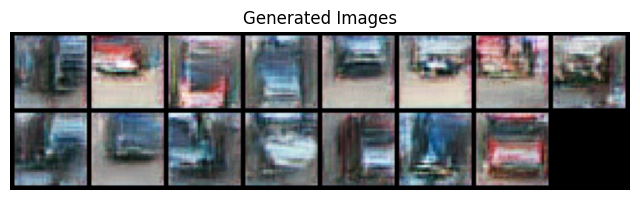

In [9]:
# Plot output images in a grid
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(img_list[-1], padding=2, normalize=True),(1,2,0)))
plt.show()

In [10]:
# Load the trained generator model for inference
inference_generator = TinyGenerator(latent_vector_size, feature_map_size, color_channels).to(device)
inference_generator.load_state_dict(torch.load("../trained/tiny_generator.pth", weights_only=True, map_location=device))
inference_generator.eval()

# Parameters
num_images = 16
imgs = []

# Generate new images
with torch.no_grad():
    for i in range(num_images):
        noise = torch.randn(1, latent_vector_size, 1, 1).to(device)
        generated_image = inference_generator(noise).detach().cpu()
        imgs.append(generated_image)


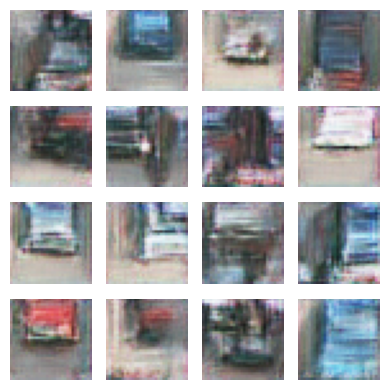

In [15]:
# Plot denormalized images
plt.figure(figsize=(4,4))
for i in range(num_images):
    plt.subplot(4, 4, i+1)
    plt.axis("off")
    plt.imshow(np.transpose(imgs[i][0], (1, 2, 0)) * 0.5 + 0.5)
plt.tight_layout()
plt.show()

In [12]:
# Save denormalized images to train_generated_imgs folder
for idx, img_tensor in enumerate(imgs):
    img = img_tensor[0]
    img = (img * 0.5 + 0.5) * 255
    img = img.numpy().astype(np.uint8)
    img = np.transpose(img, (1, 2, 0))
    pil_img = Image.fromarray(img)
    pil_img.save(f"../train_generated_imgs/generated_img_{idx+1}.png")

FileNotFoundError: [Errno 2] No such file or directory: '../train_generated_imgs/generated_img_1.png'